In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0                # gradient of loss (output) wrt current value
        self._backward = lambda: None      # function that defines how to calculate backprop gradient
        self._prev = set(_children)  # terms that make up value
        self._op = _op               # Previous operation
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # check if other is constant or Value obj
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad  # dL/dself = dn/dself * dL/dn
            other.grad += 1.0 * out.grad # dL/dself = dn/dself * dL/dn
            
        out._backward = _backward 
        return out
    
    def __radd__(self, other): # for other + self
        return self + other
    
    def __neg__(self): # for -self
        return self * -1
    
    def __sub__(self, other): # for self - other
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self, other): # for other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * (other ** -1)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float powers"
        out = Value(self.data ** other, (self, ), f"**{other}")
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
            
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        
        return out
    
    def backward(self):
        # find topological ordering of nodes, self as root
        topo = []
        visited = set()
        def topo_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topo_sort(child)
                topo.append(v)
                
        topo_sort(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [3]:
a = Value(2.0)
b = Value(4.0)

a - b

Value(data=-2.0)

In [4]:
from graphviz import Digraph

def trace(root):
    # building nodes/edges of graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)
    
    build(root)
    
    return nodes, edges

def draw_dot(root):
    # Left to Right
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        (dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" 
                  % (n.label, n.data, n.grad), shape='record'))
        # creating rectangular node for graph values
        if n._op:
            # if result of operation, create opnode
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [5]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# act function
o = n.tanh(); o.label = 'o'

In [6]:
o.backward()

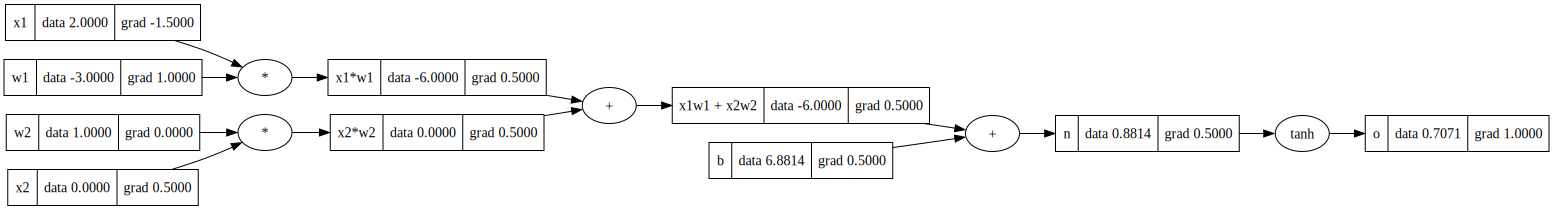

In [7]:
draw_dot(o)

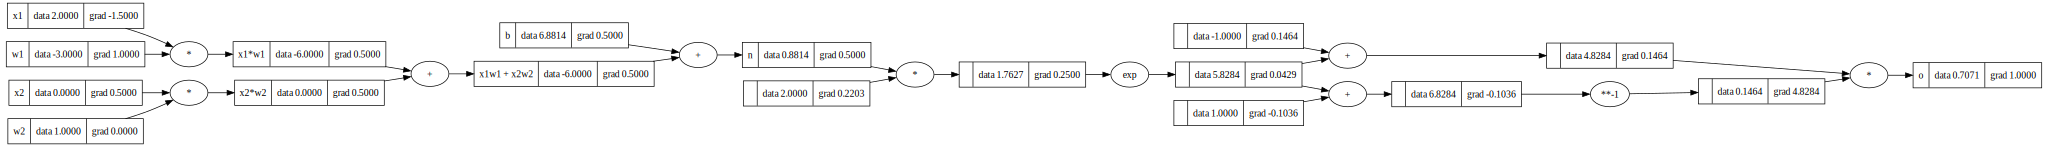

In [8]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# act function, explicit implementation of function tanh
e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()
draw_dot(o)

In [9]:
import torch
import random

In [10]:
'''Micrograd in PyTorch'''
x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double() ;  b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('x2', w2.grad.item())

0.7071066904050358
---
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
x2 0.0


In [11]:
'''NN Neuron Example'''
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        # multiply weights with input x, pairwise
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
        
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts): # nouts = list of outputs per layer
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [75]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.31634052614925207)

In [76]:
'''Example dataset'''
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1,0 -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # expected output

In [81]:
'''Optimization of weights'''

for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((ypred - y)**2 for ypred, y in zip(ypred, ys))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 0.008371612187202613
1 0.008231404422505948
2 0.008095740664356749
3 0.00796440421467121
4 0.007837191934929549
5 0.007713913201386783
6 0.007594388955486038
7 0.007478450839498519
8 0.007365940408591752
9 0.007256708411551726
10 0.007150614133275328
11 0.007047524792928089
12 0.006947314992341956
13 0.006849866209824836
14 0.006755066335076658
15 0.006662809241366922
16 0.006572994391535476
17 0.006485526474734926
18 0.006400315071151665
19 0.006317274342220894


In [82]:
ypred

[Value(data=0.964758227275136),
 Value(data=-0.950190096016574),
 Value(data=-0.9660192439436847),
 Value(data=0.9620582883829287)]